# Imports

In [102]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Creation des fichiers separes

In [103]:
data = pandas.read_csv("../data/dataNames.csv", header=0)

train_df, test_df = train_test_split(data, test_size=0.4, random_state=42)

print(train_df.size)
print(test_df.size)

train_df.to_csv("../data/train_data.csv", index=False)
test_df.to_csv("../data/test_data.csv", index=False)


10912
7296


# Parsing data

In [104]:
train_data = pandas.read_csv("../data/train_data.csv", header=0)
test_data = pandas.read_csv("../data/test_data.csv", header=0)
train_X = train_data.iloc[:, 2:] # La data sans id et diagnosis
train_Y = train_data['Diagnosis'].map({'B': 0, 'M': 1})
test_X = test_data.iloc[:, 2:] # La data sans id et diagnosis
test_Y = test_data['Diagnosis'].map({'B': 0, 'M': 1})

# numpy arrays :
train_X = train_X.to_numpy()
train_Y = train_Y.to_numpy().reshape(-1, 1)
test_X = test_X.to_numpy()
test_Y = test_Y.to_numpy().reshape(-1, 1)

# Normalisation des donnees
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_X)


print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(341, 30)
(341, 1)
(228, 30)
(228, 1)


# Creating perceptron

In [105]:
class MultilayerPerceptron :
	def __init__(self, X, Y, layers):
		self.n_layers = len(layers)
		self.W_array = []
		self.b_array = []

		for i in range(1, self.n_layers):
			self.W_array.append(np.random.randn(layers[i], layers[i-1]))
			self.b_array.append(np.random.randn(layers[i], 1))

		self.X = X
		self.Y = Y

		print(f"X dimensions:{X.shape}")
		print(f"Y dimensions:{Y.shape}")
		print(f"W dimensions:{[self.W_array[i].shape for i in range(0, self.n_layers-1)]}")
		print(f"b dimensions:{[self.b_array[i].shape for i in range(0, self.n_layers-1)]}")

	def forwardPropagation(self) :
		activations = []
		activations.append(self.X)
		for i in range(0, self.n_layers-1):
			self.Z = self.W_array[i].dot(activations[i]) + self.b_array[i]
			self.A = 1 / (1 + np.exp(-self.Z))
			activations.append(self.A)
		return activations

		# self.Z = self.X.dot(self.W) + self.b # Fait cela: Zi​=Xi​[0]∗W[0]+Xi​[1]∗W[1]+...+Xi​[29]∗W[29]+b
		# self.A = 1 / (1 + np.exp(-self.Z))

	def predict(self, X) :
		activations = []
		activations.append(X)
		for i in range(0, self.n_layers-1):
			# print(f"i: {i}")
			Z = self.W_array[i].dot(activations[i]) + self.b_array[i]
			A = 1 / (1 + np.exp(-Z))
			activations.append(A)
		return A

	def log_loss(self) :
		eps = 1e-15 
		A_clipped = np.clip(self.A, eps, 1 - eps) # pour éviter log(0) (empeche les valeures d'etre en dehors de l'interval 𝐴∈[10**−15,1−10**−15]
		result = -1 / self.X.shape[0] * np.sum(self.Y * np.log(A_clipped) + (1 - self.Y) * np.log(1 - A_clipped))
		return result

	def backPropagation(self, activations) :
		m = self.X.shape[1] # Taille du dataset

		dZ = activations[self.n_layers - 1] - self.Y
		gradients_dW = []
		gradients_db = []

		for i in reversed(range(1, self.n_layers)):
			gradients_dW.insert(0, 1/m * np.dot(dZ, activations[i-1].T))
			gradients_db.insert(0, 1/m * np.sum(dZ, axis=1, keepdims=True))
			# print(f"dw{i} shape is {(1/m * np.dot(dZ, activations[i-1].T)).shape}")
			# print(f"db{i} shape is {(1/m * np.sum(dZ, axis=1, keepdims=True)).shape}")
			if i > 1:
				dZ = np.dot(self.W_array[i-1].T, dZ) * activations[i-1] * (1 - activations[i-1])
		
		return gradients_dW, gradients_db
		
	def update(self, gradient_dW, gradient_db, learning_rate):
		for i in range(0, self.n_layers - 1):
			self.W_array[i] -= learning_rate * gradient_dW[i]
			self.b_array[i] -= learning_rate * gradient_db[i]


# Testing perceptron

X dimensions:(30, 341)
Y dimensions:(1, 341)
W dimensions:[(1, 30)]
b dimensions:[(1, 1)]


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 27248.66it/s]


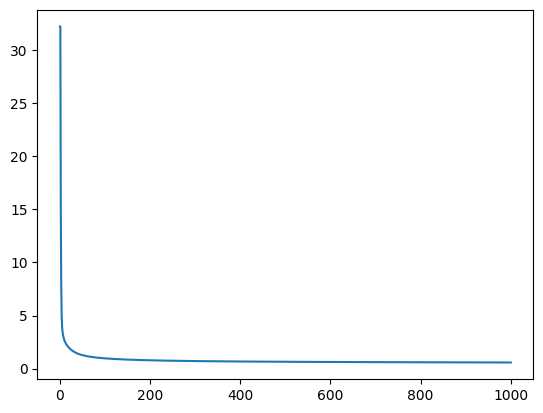

In [106]:
m = MultilayerPerceptron(X_scaled.T, train_Y.T, [30, 1])
Loss = []
activations = m.forwardPropagation()
# print(activations[3].shape)
Loss.append(m.log_loss())

for i in tqdm(range(1000)):
    activations = m.forwardPropagation()
    gradients_dW, gradients_db = m.backPropagation(activations)
    # print(gradients_dW[0].shape)
    m.update(gradients_dW, gradients_db, 0.5)
    Loss.append(m.log_loss())

plt.plot(Loss)
plt.show()

# Revoir les calculs de gradient et la fonction update pour corriger les bugs


# Fonction accuracy

In [107]:
def model_accuracy(p: MultilayerPerceptron, X, Y) :
	A = p.predict(X)[0]
	# print(A)
	# print(A.shape)
	accuracy: int = 0
	for i in range(0, Y.shape[0]) :
		if (A[i] > 0.5) == Y[i] :
			accuracy += 1
	print("Accuracy: ", accuracy / Y.shape[0] * 100)

from sklearn.metrics import confusion_matrix

def model_confusion(p: MultilayerPerceptron, X, Y):
    preds = (p.predict(X)[0] > 0.5).astype(int)
    print(confusion_matrix(Y, preds))

test_X_scaled = scaler.fit_transform(test_X)
model_accuracy(m, test_X_scaled.T, test_Y)
model_confusion(m, test_X_scaled.T, test_Y)

Accuracy:  98.68421052631578
[[146   2]
 [  1  79]]
